# Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
pd.set_option('display.max_columns', None)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

In [6]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
from torch import optim

# Import

In [7]:
df_train = pd.read_csv('./train.csv')

In [8]:
df_train.head(10)

,SMILES,SENTENCE
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose"
1,COC(=O)OC,"fresh,ethereal,fruity"
2,Cc1cc2c([nH]1)cccc2,"resinous,animalic"
3,C1CCCCCCCC(=O)CCCCCCC1,"powdery,musk,animalic"
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"coniferous,camphor,fruity"
5,CCC[C@H](CCO)SC,tropicalfruit
6,CC(C)C(=O)OCc1ccco1,"fruity,coffee"
7,OC[C@H]1[C@H]2CC[C@H]3[C@@]1(C)CCCC([C@@H]23)(C)C,woody
8,CCc1ccc(cc1)CC(C=O)(C)C,"clean,fresh"
9,CC(C)[C@@H]1CC[C@@](C)([C@H]2CCC(=C[C@@H]12)C)O,"herbal,spicy,honey"


In [9]:
df_train.SMILES = df_train.SMILES.apply(lambda x: x.replace(' ','').replace('\\','|'))

In [10]:
vocab = [word.replace('\n','') for word in open('./vocabulary.txt').readlines()]

In [11]:
vocab_to_label = {j:i for i,j in enumerate(vocab)}
print(vocab_to_label)

{'alcoholic': 0, 'aldehydic': 1, 'alliaceous': 2, 'almond': 3, 'ambergris': 4, 'ambery': 5, 'ambrette': 6, 'ammoniac': 7, 'animalic': 8, 'anisic': 9, 'apple': 10, 'balsamic': 11, 'banana': 12, 'berry': 13, 'blackcurrant': 14, 'blueberry': 15, 'body': 16, 'bread': 17, 'burnt': 18, 'butter': 19, 'cacao': 20, 'camphor': 21, 'caramellic': 22, 'cedar': 23, 'cheese': 24, 'chemical': 25, 'cherry': 26, 'cinnamon': 27, 'citrus': 28, 'clean': 29, 'clove': 30, 'coconut': 31, 'coffee': 32, 'cognac': 33, 'coniferous': 34, 'cooked': 35, 'cooling': 36, 'cucumber': 37, 'dairy': 38, 'dry': 39, 'earthy': 40, 'ester': 41, 'ethereal': 42, 'fatty': 43, 'fennel': 44, 'fermented': 45, 'floral': 46, 'fresh': 47, 'fruity': 48, 'geranium': 49, 'gourmand': 50, 'grape': 51, 'grapefruit': 52, 'grass': 53, 'green': 54, 'herbal': 55, 'honey': 56, 'hyacinth': 57, 'jasmin': 58, 'lactonic': 59, 'leaf': 60, 'leather': 61, 'lemon': 62, 'lily': 63, 'liquor': 64, 'meat': 65, 'medicinal': 66, 'melon': 67, 'metallic': 68, 'm

In [12]:
df_test = pd.read_csv('./test.csv')

In [13]:
df_test.head()

,SMILES
0,CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C
1,CC(C)C1CCC(C)CC1OC(=O)CC(C)O
2,CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C
3,CC(=O)OCC(COC(=O)C)OC(=O)C
4,CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C


In [14]:
df_test.SMILES = df_test.SMILES.apply(lambda x: x.replace(' ','').replace('\\','|'))

# Preprocessing

In [15]:
num_characters = len(set(''.join(df_train.SMILES.unique())))
num_classes = len(vocab)

## Max lenght

<AxesSubplot:ylabel='Frequency'>

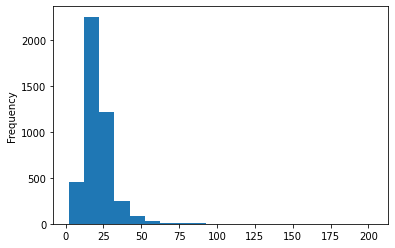

In [16]:
df_train.SMILES.apply(lambda x: len(x)).plot(kind='hist', bins=20)

In [17]:
cut_off_molecule = 64
print((df_train.SMILES.apply(lambda x: len(x))<cut_off_molecule).sum()/df_train.shape[0])
print((df_train.SMILES.apply(lambda x: len(x))>=cut_off_molecule).sum())

0.9930491195551436
30


## Encode unigrams

In [18]:
character_to_index_unigram = {j:i+1 for i,j in enumerate(set(''.join(df_train.SMILES.unique())))}
print(character_to_index_unigram)

{'#': 1, 'r': 2, 'c': 3, 'F': 4, '(': 5, '.': 6, 'P': 7, '=': 8, '3': 9, '-': 10, '4': 11, 'B': 12, 'n': 13, ']': 14, '|': 15, 'a': 16, 'l': 17, '/': 18, 'S': 19, '1': 20, 'N': 21, 'H': 22, ')': 23, 'O': 24, '2': 25, '+': 26, 'o': 27, '@': 28, 'C': 29, '[': 30, '*': 31, 'e': 32, 's': 33, 'Z': 34}


In [19]:
def encode_ngrams(data, n, dic_word_to_index, max_length):
    def encode(x):
        encoded_x = []
        for i in range(min(cut_off_molecule,len(x)-n+1)):
            if x[i:i+n] in dic_word_to_index:
                encoded_x.append(dic_word_to_index[x[i:i+n]])
            else:
                encoded_x.append(0)
        encoded_x = [0]*(max_length-len(encoded_x)) + encoded_x
        if len(encoded_x)==65:
            print(cut_off_molecule,len(x)-n+1)
            print(encoded_x)
        return np.array(encoded_x)
           
    return pd.DataFrame(data.SMILES.apply(lambda x: encode(x)).to_list(), columns=[str(n)+'_'+str(i) for i in range(max_length)])

In [20]:
unigrams_train = encode_ngrams(df_train, 1, character_to_index_unigram, cut_off_molecule)
unigrams_test = encode_ngrams(df_test, 1, character_to_index_unigram, cut_off_molecule)

## Encode bigrams

In [21]:
from nltk.util import ngrams
def extract_ngrams(data, n):
    n_grams=[]
    for i, molecule in enumerate(data):
        for j in range(len(molecule)-n+1):
            n_grams.append(molecule[j:j+n])
    return n_grams

In [22]:
character_to_index_bigram = {j:i+1 for i,j in enumerate(set(extract_ngrams(df_train.SMILES.to_numpy(),2)))}

In [23]:
bigrams_train = encode_ngrams(df_train, 2, character_to_index_bigram, cut_off_molecule)
bigrams_test = encode_ngrams(df_test, 2, character_to_index_bigram, cut_off_molecule)

## Encode trigrams

In [24]:
character_to_index_trigram = {j:i+1 for i,j in enumerate(set(extract_ngrams(df_train.SMILES.to_numpy(),3)))}

In [25]:
trigrams_train = encode_ngrams(df_train, 3, character_to_index_trigram, cut_off_molecule)
trigrams_test = encode_ngrams(df_test, 3, character_to_index_trigram, cut_off_molecule)

## Extract global information

In [26]:
scaler = StandardScaler()
vectorizer = CountVectorizer(analyzer='char', lowercase=False)
counter_train = vectorizer.fit_transform(df_train.SMILES.values)
counter_train = pd.DataFrame(scaler.fit_transform([k for k in counter_train.toarray()]),columns=['count_'+str(i) for i in range(len(vectorizer.vocabulary_))])

counter_test = vectorizer.transform(df_test.SMILES.values)
counter_test = pd.DataFrame(scaler.transform([k for k in counter_test.toarray()]),columns=['count_'+str(i) for i in range(len(vectorizer.vocabulary_))])

## Encode target

In [27]:
df_train.SENTENCE

0                     fruity,rose
1           fresh,ethereal,fruity
2               resinous,animalic
3           powdery,musk,animalic
4       coniferous,camphor,fruity
                  ...            
4311                floral,citrus
4312                watery,earthy
4313               sweet,ethereal
4314                          nut
4315                 woody,floral
Name: SENTENCE, Length: 4316, dtype: object

In [28]:
targets = np.zeros((df_train.shape[0],len(vocab)))

In [29]:
for index,labels in enumerate(df_train.SENTENCE):
    for label in labels.split(','):
        targets[index,vocab_to_label[label]]=1

## Weights of each class

In [30]:
pos_weights = (pd.DataFrame(targets).sum()/(len(targets)-pd.DataFrame(targets).sum())).to_numpy()

# Split

In [31]:
X = pd.concat([unigrams_train, bigrams_train, trigrams_train, counter_train], axis=1)
X_test = pd.concat([unigrams_test, bigrams_test, trigrams_test, counter_test], axis=1)

In [32]:
X.head()

,1_0,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,1_11,1_12,1_13,1_14,1_15,1_16,1_17,1_18,1_19,1_20,1_21,1_22,1_23,1_24,1_25,1_26,1_27,1_28,1_29,1_30,1_31,1_32,1_33,1_34,1_35,1_36,1_37,1_38,1_39,1_40,1_41,1_42,1_43,1_44,1_45,1_46,1_47,1_48,1_49,1_50,1_51,1_52,1_53,1_54,1_55,1_56,1_57,1_58,1_59,1_60,1_61,1_62,1_63,2_0,2_1,2_2,2_3,2_4,2_5,2_6,2_7,2_8,2_9,2_10,2_11,2_12,2_13,2_14,2_15,2_16,2_17,2_18,2_19,2_20,2_21,2_22,2_23,2_24,2_25,2_26,2_27,2_28,2_29,2_30,2_31,2_32,2_33,2_34,2_35,2_36,2_37,2_38,2_39,2_40,2_41,2_42,2_43,2_44,2_45,2_46,2_47,2_48,2_49,2_50,2_51,2_52,2_53,2_54,2_55,2_56,2_57,2_58,2_59,2_60,2_61,2_62,2_63,3_0,3_1,3_2,3_3,3_4,3_5,3_6,3_7,3_8,3_9,3_10,3_11,3_12,3_13,3_14,3_15,3_16,3_17,3_18,3_19,3_20,3_21,3_22,3_23,3_24,3_25,3_26,3_27,3_28,3_29,3_30,3_31,3_32,3_33,3_34,3_35,3_36,3_37,3_38,3_39,3_40,3_41,3_42,3_43,3_44,3_45,3_46,3_47,3_48,3_49,3_50,3_51,3_52,3_53,3_54,3_55,3_56,3_57,3_58,3_59,3_60,3_61,3_62,3_63,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,count_10,count_11,count_12,count_13,count_14,count_15,count_16,count_17,count_18,count_19,count_20,count_21,count_22,count_23,count_24,count_25,count_26,count_27,count_28,count_29,count_30,count_31,count_32,count_33
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,18,29,8,29,18,29,5,8,24,23,29,20,29,29,29,5,29,8,29,20,29,23,5,29,23,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105,204,112,43,105,204,123,191,194,88,207,97,212,45,45,123,161,112,43,97,212,15,14,161,15,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,141,160,745,733,141,349,619,396,692,172,780,546,442,782,533,73,394,745,575,546,460,290,184,241,626,-0.128449,0.549842,0.549842,-0.015223,-0.060999,-0.064317,-0.092425,1.827733,0.461043,-0.432236,-0.160231,-0.050549,1.458150,-0.266828,-0.026374,0.808553,-0.015223,-0.268535,-0.196077,-0.494957,-0.027522,-0.25597,-0.015223,-0.281085,-0.281085,-0.043983,-0.619178,-0.015223,-0.04354,-0.210453,-0.165247,-0.021532,-0.122743,-0.248907
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,24,29,5,8,24,23,24,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,19,123,191,194,88,119,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,239,831,619,396,692,661,821,-0.128449,-0.775182,-0.775182,-0.015223,-0.060999,-0.064317,-0.092425,-0.368702,-1.144979,-0.432236,-0.160231,-0.050549,-0.264175,-0.266828,-0.026374,-1.193808,-0.015223,-0.268535,-0.196077,1.105219,-0.027522,-0.25597,-0.015223,-0.281085,-0.281085,-0.043983,-0.619178,-0.015223,-0.04354,-0.210453,-0.165247,-0.021532,-0.122743,-0.248907
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,3,20,3,3,25,3,5,30,13,22,14,20,23,3,3,3,3,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208,141,144,116,221,165,122,140,150,46,109,33,64,145,116,116,116,221,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,307,607,33,250,563,319,735,463,143,95,699,270,262,296,16,16,250,-0.128449,-0.775182,-0.775182,-0.015223,-0.060999,-0.064317,-0.092425,-0.368702,0.461043,2.119791,-0.160231,-0.050549,-1.125337,-0.266828,-0.026374,-1.594280,-0.015223,1.226944,-0.196077,-1.295046,-0.027522,-0.25597,-0.015223,0.945571,0.945571,-0.043983,1.836764,-0.015223,-0.04354,2.312648,-0.165247,-0.021532,-0.122743,-0.248907
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,20,29,29,29,29,29,29,29,29,5,8,24,23,29,29,29,29,29,29,29,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,97,212,45,45,45,45,45,45,45,123,191,194,88,207,45,45,45,45,45,45,97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,546,4

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, targets, train_size = 0.95)

In [34]:
X_train.head()

,1_0,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,1_11,1_12,1_13,1_14,1_15,1_16,1_17,1_18,1_19,1_20,1_21,1_22,1_23,1_24,1_25,1_26,1_27,1_28,1_29,1_30,1_31,1_32,1_33,1_34,1_35,1_36,1_37,1_38,1_39,1_40,1_41,1_42,1_43,1_44,1_45,1_46,1_47,1_48,1_49,1_50,1_51,1_52,1_53,1_54,1_55,1_56,1_57,1_58,1_59,1_60,1_61,1_62,1_63,2_0,2_1,2_2,2_3,2_4,2_5,2_6,2_7,2_8,2_9,2_10,2_11,2_12,2_13,2_14,2_15,2_16,2_17,2_18,2_19,2_20,2_21,2_22,2_23,2_24,2_25,2_26,2_27,2_28,2_29,2_30,2_31,2_32,2_33,2_34,2_35,2_36,2_37,2_38,2_39,2_40,2_41,2_42,2_43,2_44,2_45,2_46,2_47,2_48,2_49,2_50,2_51,2_52,2_53,2_54,2_55,2_56,2_57,2_58,2_59,2_60,2_61,2_62,2_63,3_0,3_1,3_2,3_3,3_4,3_5,3_6,3_7,3_8,3_9,3_10,3_11,3_12,3_13,3_14,3_15,3_16,3_17,3_18,3_19,3_20,3_21,3_22,3_23,3_24,3_25,3_26,3_27,3_28,3_29,3_30,3_31,3_32,3_33,3_34,3_35,3_36,3_37,3_38,3_39,3_40,3_41,3_42,3_43,3_44,3_45,3_46,3_47,3_48,3_49,3_50,3_51,3_52,3_53,3_54,3_55,3_56,3_57,3_58,3_59,3_60,3_61,3_62,3_63,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,count_10,count_11,count_12,count_13,count_14,count_15,count_16,count_17,count_18,count_19,count_20,count_21,count_22,count_23,count_24,count_25,count_26,count_27,count_28,count_29,count_30,count_31,count_32,count_33
1179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,29,5,29,5,8,24,23,24,29,29,24,3,20,3,3,3,3,3,20,23,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,123,161,123,191,194,88,119,19,45,53,143,141,144,116,116,116,116,141,64,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,533,73,723,619,396,692,661,821,698,479,6,344,607,33,16,16,16,217,404,830,-0.128449,-0.112670,-0.112670,-0.015223,-0.060999,-0.064317,-0.092425,-0.368702,0.461043,-0.432236,-0.160231,-0.050549,-0.264175,-0.266828,-0.026374,-0.593100,-0.015223,-0.268535,-0.196077,1.105219,-0.027522,-0.255970,-0.015223,-0.281085,-0.281085,-0.043983,1.222778,-0.015223,-0.04354,-0.210453,-0.165247,-0.021532,-0.122743,-0.248907
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,29,29,30,29,28,22,14,5,29,29,24,23,19,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,45,21,195,34,5,109,70,161,45,53,88,149,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,782,82,649,237,79,104,662,466,681,479,517,210,811,-0.128449,-0.775182,-0.775182,-0.015223,-0.060999,-0.064317,-0.092425,-0.368702,-1.144979,-0.432236,-0.160231,-0.050549,-1.125337,0.551673,-0.026374,-0.392863,-0.015223,1.226944,-0.196077,-0.494957,-0.027522,2.331309,-0.015223,0.945571,0.945571,-0.043983,-0.619178,-0.015223,-0.04354,-0.210453,-0.165247,-0.021532,-0.122743,-0.248907
4279,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,29,29,29,29,5,29,29,29,5,8,24,23,24,23,29,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,45,45,45,123,161,45,45,123,191,194,88,119,88,207,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,782,782,782,533,73,681,782,533,619,396,692,661,761,172,592,-0.128449,-0.112670,-0.112670,-0.015223,-0.060999,-0.064317,-0.092425,-0.368702,-1.144979,-0.432236,-0.160231,-0.050549,-0.264175,-0.266828,-0.026374,0.207845,-0.015223,-0.268535,-0.196077,0.305131,-0.027522,-0.255970,-0.015223,-0.281085,-0.281085,-0.043983,-0.619178,-0.015223,-0.04354,-0.210453,-0.165247,-0.021532,-0.122743,-0.248907
1634,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,1,29,29,5,29,29,29,8,29,5,29,23,29,23,5,24,23,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,217,94,45,123,161,45,45,112,43,123,161,15,207,15,14,114,88,207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,665

# Models

In [35]:
cut_off_molecule

64

In [36]:
class HPS:
    num_classes = num_classes
    vocab_size_unigram = len(character_to_index_unigram)
    vocab_size_bigram = len(character_to_index_bigram)
    vocab_size_trigram = len(character_to_index_trigram)
    num_characters = len(set(''.join(df_train.SMILES.unique())))
    sentence_length = cut_off_molecule
    embedding_dim = 8
    hidden_dim = 128
    fully_connected_dim = 128
    fc1_dim = 128
    lstm_layer = 2
    dropout = 0.25
    epochs = 10
    batch_size = 64
    learning_rate = 0.001

hps = HPS()

In [37]:
class BiLSTMCell(nn.Module):
    def __init__(self, hps, vocab_dim):
        super(BiLSTMCell, self).__init__()
        self.hps = hps
        self.hidden_dim = hps.hidden_dim
        self.dropout = nn.Dropout(p=hps.dropout)
        self.embedding = nn.Embedding(vocab_dim+1, hps.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hps.hidden_dim,
                            num_layers=hps.lstm_layer, 
                            dropout = hps.dropout,
                            bidirectional=True)
        self.hidden2label = nn.Linear(hps.hidden_dim*hps.lstm_layer*2, hps.fully_connected_dim)
    
    def forward(self, sents):
        x = self.embedding(sents)
        x = torch.transpose(x, dim0=1, dim1=0)
        lstm_out, (h_n, c_n) = self.lstm(x)
        y = self.hidden2label(self.dropout(torch.cat([c_n[i,:, :] for i in range(c_n.shape[0])], dim=1)))
        return y

In [38]:
class BiLSTM(nn.Module):
    def __init__(self, hps):
        super(BiLSTM, self).__init__()
        self.hps = hps
        self.unigram_lstm = BiLSTMCell(hps, hps.vocab_size_unigram)
        self.bigram_lstm = BiLSTMCell(hps, hps.vocab_size_bigram)
        self.trigram_lstm = BiLSTMCell(hps, hps.vocab_size_trigram)
        self.fc1 = nn.Linear(hps.fully_connected_dim*3+num_characters, hps.fc1_dim)
        self.batchnorm = nn.BatchNorm1d(hps.fully_connected_dim*3+num_characters)
        self.fc2 = nn.Linear(hps.fc1_dim, hps.num_classes)
        
    def forward(self, X):
        output_unigram = self.unigram_lstm(X[:,:self.hps.sentence_length])
        output_bigram = self.bigram_lstm(X[:,self.hps.sentence_length:2*self.hps.sentence_length])
        output_trigram = self.trigram_lstm(X[:,2*self.hps.sentence_length:3*self.hps.sentence_length])
        concat_ngrams = torch.cat([output_unigram,output_bigram,output_trigram,X[:,3*self.hps.sentence_length:].float()], dim=1)
        concat_ngrams = self.batchnorm(concat_ngrams)
        output = self.fc1(concat_ngrams)
        output = self.fc2(output)
        return output

In [ ]:
class Classifier():
    
    def __init__(self, hps):
        self.hps = hps
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = BiLSTM(hps).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr = hps.learning_rate)
        self.nb_epochs_already_trained = 0
        self.batch_train_losses = []
        self.train_losses = []
        self.val_losses = []
        
    def train(self, X_train, y_train, X_val=None, y_val=None, early_stopping=False):    
        X_train = torch.LongTensor(X_train.to_numpy())
        y_train = torch.Tensor(np.array(y_train))
        
        permutation = torch.randperm(X_train.size()[0])
        loss_f = nn.BCEWithLogitsLoss()
#         loss_f = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(pos_weights).to(self.device))
                
        for epoch in range(self.hps.epochs):
            print(f'Epochs: {epoch+1+self.nb_epochs_already_trained}/{self.hps.epochs+self.nb_epochs_already_trained}',end='')
            self.batch_train_losses.append([])
            for i in trange(0, X_train.size()[0], self.hps.batch_size):
                self.optimizer.zero_grad()
                
                indices = permutation[i:i+self.hps.batch_size]
                batch_X, batch_y = X_train[indices].to(self.device), y_train[indices].to(self.device)
        
                output = self.model(batch_X)
                loss = loss_f(output, batch_y)
                
                loss.backward()
                self.optimizer.step()
                self.batch_train_losses[-1].append(float(loss))
                
            output_train = self.predict(X_train)
            loss_train = float(nn.BCEWithLogitsLoss()(output_train, y_train))
            self.train_losses.append(loss_train)
            print('loss_train =',round(loss_train,5), end='')
            if X_val is not None:
                output_val = self.predict(torch.LongTensor(X_val.to_numpy()))
                loss_val = float(nn.BCEWithLogitsLoss()(output_val, torch.Tensor(np.array(y_val))))
                self.val_losses.append(loss_val)
                print(', loss_val =',round(loss_val,5),end='')
                if early_stopping & len(self.val_losses)>2:
                    if self.val_losses[-2]<self.val_losses[-1]:
                        print('Early stopping at epoch',epoch)
                        break                    
            print('\n')
                
        self.nb_epochs_already_trained += epoch+1
        
                
                
    def predict(self, X):
        X = X.to(self.device)
        y_pred = torch.empty((0, hps.num_classes), dtype=torch.float).to(self.device)
        for i in range(0,X.shape[0],hps.batch_size):
            batch_X = X[i:i+hps.batch_size]
            y_pred = torch.cat((y_pred,self.model(batch_X).detach()),dim=0)
        return y_pred
    
    def plot_train_curve(self):
        plt.figure(figsize=(10,5))
        plt.grid()
        plt.plot(self.train_losses, linewidth=2)
        plt.plot(self.val_losses, linewidth=2)
        plt.legend(['Train','Validation'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'model.pth')
    
    def load(self):
        if os.path.isfile('model.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('model.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")
            
classifier = Classifier(hps)
classifier.train(X_train, y_train, X_val, y_val)

Epochs: 1/10

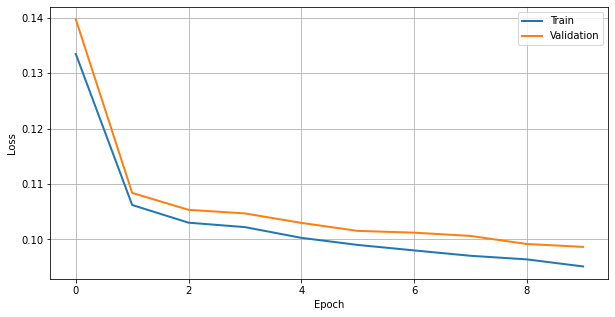

In [38]:
classifier.plot_train_curve()

# Prediction on X_test

In [39]:
y_pred = np.array(classifier.predict(torch.LongTensor(X_test.to_numpy())).sigmoid().tolist())

In [40]:
def get_top_index(y_pred, n):
    indexes = []
    for a in y_pred:
        indexes.append(sorted(range(len(a)), key=lambda i: a[i])[-n:])
    return np.array(indexes)

In [41]:
label_to_vocab = {v: k for k, v in vocab_to_label.items()}
combinations = np.array([[0,1,2],[0,1,3],[0,2,3],[1,2,3],[0,1,4]])

In [42]:
def build_submission(y_pred):
    top_indexes = get_top_index(y_pred, 5)
    result = []
    for i, indexes in enumerate(top_indexes):
        solution=''
        for combination in combinations:
            s=[]
            for index in indexes[list(combination)]:
                s.append(label_to_vocab[index])
            solution+=','.join(s)+';'
        result.append(solution[:-1])
    return result
            
sub = build_submission(y_pred)

In [43]:
sub = pd.concat((df_test.SMILES,pd.Series(sub).rename('PREDICTIONS')),axis=1)

In [44]:
sub.head()

,SMILES,PREDICTIONS
0,CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C,"fresh,camphor,fruity;fresh,camphor,herbal;fres..."
1,CC(C)C1CCC(C)CC1OC(=O)CC(C)O,"floral,herbal,woody;floral,herbal,sweet;floral..."
2,CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C,"floral,woody,herbal;floral,woody,fresh;floral,..."
3,CC(=O)OCC(COC(=O)C)OC(=O)C,"caramellic,ethereal,fresh;caramellic,ethereal,..."
4,CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)|C,"oily,citrus,fatty;oily,citrus,waxy;oily,fatty,..."


In [47]:
sub.PREDICTIONS[0]

'fresh,camphor,fruity;fresh,camphor,herbal;fresh,fruity,herbal;camphor,fruity,herbal;fresh,camphor,woody'

In [46]:
sub.to_csv('submission.csv', index=False)